In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-12-29 14:43:14.934907: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-29 14:43:14.972818: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 14:43:14.972845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 14:43:14.972850: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 14:43:14.978825: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
def train_val_generators(TRAINING_DIR):

  # Instantiate the ImageDataGenerator class
  validation_split=0.1
  # Don't forget to normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(validation_split=validation_split)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      subset='training')
  
  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      subset='validation')

  return train_generator, validation_generator

In [4]:
train_dir = 'pisang/pisang_artificial_ripen/Train'

In [5]:
# Test generators
train_generator, validation_generator = train_val_generators(train_dir)

Found 7233 images belonging to 12 classes.
Found 800 images belonging to 12 classes.


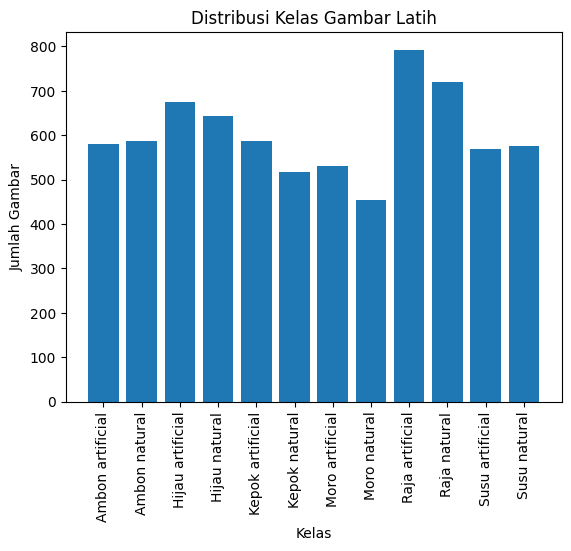

In [6]:
# Menghitung jumlah data per kelas
num_classes_train = len(train_generator.class_indices)
class_counts_train = np.zeros(num_classes_train)

for i in range(len(train_generator)):
    batch_labels_train = np.argmax(train_generator[i][1], axis=1)
    class_counts_train += np.bincount(batch_labels_train, minlength=num_classes_train)

# Mendapatkan nama kelas
class_names_train = list(train_generator.class_indices.keys())

plt.bar(class_names_train, class_counts_train)
plt.title('Distribusi Kelas Gambar Latih')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=90)
plt.show()

## MobileNetV3-Small SGD 0.1-0.0001

In [6]:
pretrained_mobile = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    input_shape=(224, 224, 3)
)

2023-12-29 14:43:31.951182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18236 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


In [7]:
x2 = pretrained_mobile.output
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
predictions2 = tf.keras.layers.Dense(12, activation='softmax')(x2)
model = tf.keras.Model(inputs=pretrained_mobile.input, outputs=predictions2)
#model2.summary()

### 0,1 - 0,4

#### 0,1

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,1.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,1.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)

Epoch 1/100


2023-12-28 14:52:23.275952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-28 14:52:28.209188: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 14:52:28.836692: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 14:52:44.739639: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a5cbe15490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 14:52:44.739702: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-28 14:52:44.749507: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-28 14:52:44.900514: I ./tensorflow/compiler/jit/device_compiler.h:1

453/453 [==============================] - ETA: 0s - loss: 2.3305 - accuracy: 0.2710
Epoch 1: val_accuracy improved from -inf to 0.09875, saving model to new_test/new-test-mobile-adam-0,1.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 143s 164ms/step - loss: 2.3305 - accuracy: 0.2710 - val_loss: 7511958.5000 - val_accuracy: 0.0988
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.4203 - accuracy: 0.4079
Epoch 2: val_accuracy improved from 0.09875 to 0.11000, saving model to new_test/new-test-mobile-adam-0,1.h5
453/453 [==============================] - 36s 78ms/step - loss: 1.4203 - accuracy: 0.4079 - val_loss: 61855.3164 - val_accuracy: 0.1100
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.1996 - accuracy: 0.4695
Epoch 3: val_accuracy did not improve from 0.11000
453/453 [==============================] - 35s 77ms/step - loss: 1.1996 - accuracy: 0.4695 - val_loss: 1911.0306 - val_accuracy: 0.1063
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.1804 - accuracy: 0.4666
Epoch 4: val_accuracy did not improve from 0.11000
453/453 [==============================] - 35s 77ms/step - loss: 1.1804 - accuracy: 

In [10]:
model.save('new_test/new-test-mobile-adam-0,1-completed.h5')

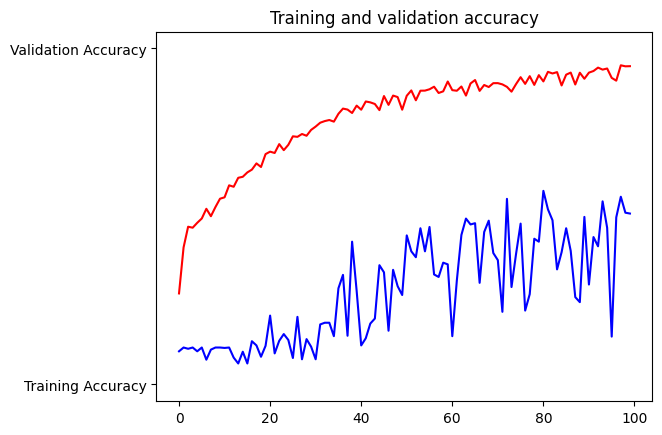

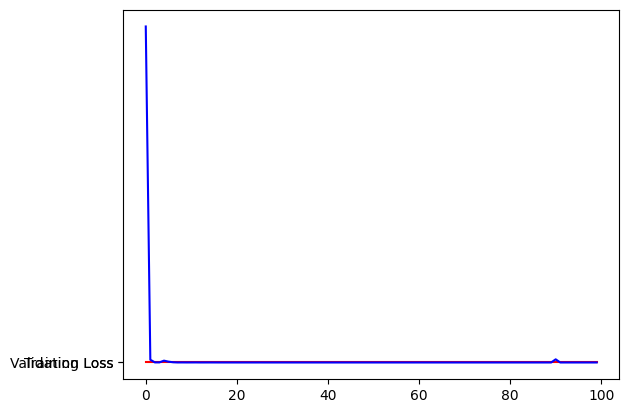

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,2

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.2)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,2.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,2.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)

Epoch 1/100


2023-12-28 15:52:51.586329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-28 15:52:53.544708: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 15:52:53.868072: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 15:52:57.907003: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562a7044dd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 15:52:57.907076: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-28 15:52:57.920895: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-28 15:52:58.089104: I ./tensorflow/compiler/jit/device_compiler.h:1

453/453 [==============================] - ETA: 0s - loss: 2.4423 - accuracy: 0.2942
Epoch 1: val_accuracy improved from -inf to 0.07875, saving model to new_test/new-test-mobile-adam-0,2.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 78s 93ms/step - loss: 2.4423 - accuracy: 0.2942 - val_loss: 5127927.5000 - val_accuracy: 0.0787
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.5973 - accuracy: 0.3893
Epoch 2: val_accuracy improved from 0.07875 to 0.08125, saving model to new_test/new-test-mobile-adam-0,2.h5
453/453 [==============================] - 35s 76ms/step - loss: 1.5973 - accuracy: 0.3893 - val_loss: 48120.9062 - val_accuracy: 0.0812
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.3618 - accuracy: 0.4361
Epoch 3: val_accuracy did not improve from 0.08125
453/453 [==============================] - 33s 73ms/step - loss: 1.3618 - accuracy: 0.4361 - val_loss: 207540.1406 - val_accuracy: 0.0712
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.2166 - accuracy: 0.4604
Epoch 4: val_accuracy did not improve from 0.08125
453/453 [==============================] - 35s 77ms/step - loss: 1.2166 - accuracy: 

In [9]:
model.save('new_test/new-test-mobile-adam-0,2-completed.h5')

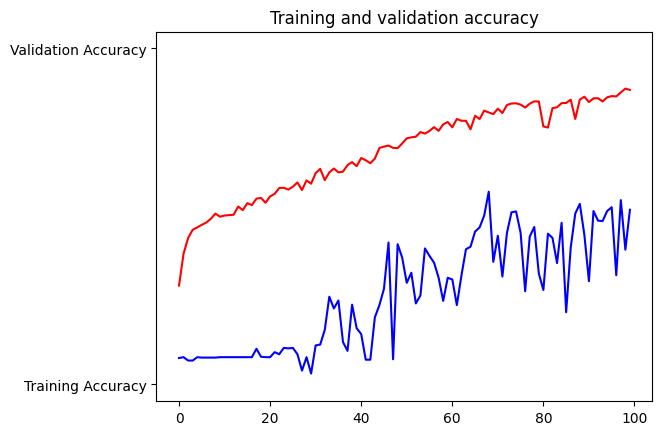

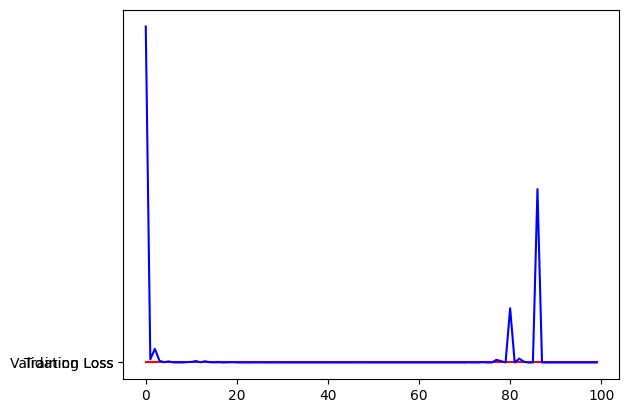

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,3

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.3)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,3.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,3.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,3-completed.h5')

Epoch 1/100


2023-12-28 17:28:25.026862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-28 17:28:29.851853: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 17:28:30.557936: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 17:28:45.673047: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556311be6cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 17:28:45.673097: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-28 17:28:45.680018: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-28 17:28:45.836248: I ./tensorflow/compiler/jit/device_compiler.h:1

453/453 [==============================] - ETA: 0s - loss: 2.5568 - accuracy: 0.2851
Epoch 1: val_accuracy improved from -inf to 0.08875, saving model to new_test/new-test-mobile-adam-0,3.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 145s 170ms/step - loss: 2.5568 - accuracy: 0.2851 - val_loss: 47922812.0000 - val_accuracy: 0.0887
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.5166 - accuracy: 0.3866
Epoch 2: val_accuracy did not improve from 0.08875
453/453 [==============================] - 42s 92ms/step - loss: 1.5166 - accuracy: 0.3866 - val_loss: 202199.0156 - val_accuracy: 0.0887
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.4090
Epoch 3: val_accuracy did not improve from 0.08875
453/453 [==============================] - 43s 95ms/step - loss: 1.3794 - accuracy: 0.4090 - val_loss: 31128.0605 - val_accuracy: 0.0887
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.3037 - accuracy: 0.4337
Epoch 4: val_accuracy did not improve from 0.08875
453/453 [==============================] - 40s 88ms/step - loss: 1.3037 - accuracy: 0.4337 - val_loss: 72200.5469 - val_accuracy: 0.0887
Ep

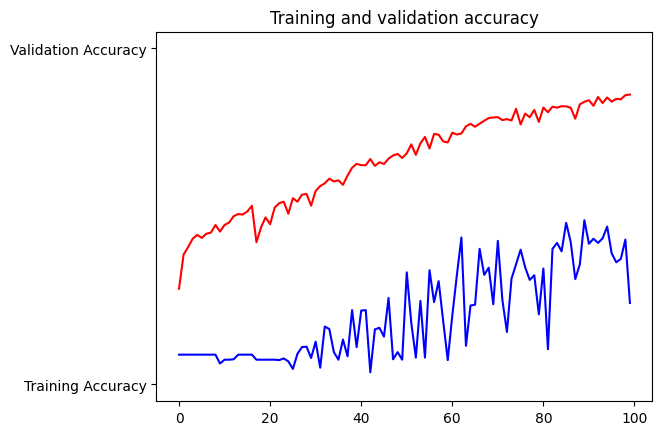

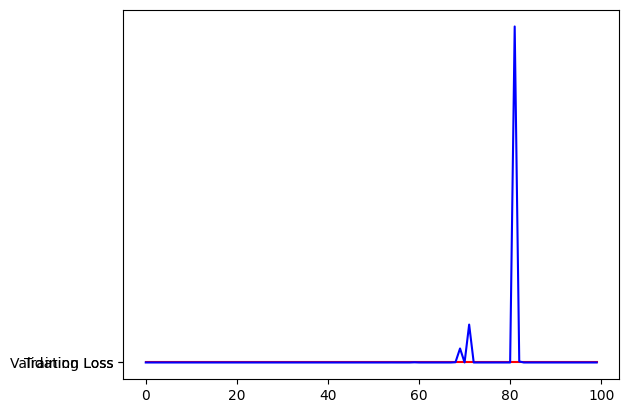

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,4

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.4)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,4.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,4.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,4-completed.h5')

Epoch 1/100


2023-12-29 14:43:45.270565: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-29 14:43:49.431541: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-29 14:43:51.365293: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-29 14:43:52.593291: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ef36ecbd6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 14:43:52.593386: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-29 14:43:52.696292: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-29 14:43:52.969453: I ./tensorflow/compiler/jit/device_compiler.h:1

453/453 [==============================] - ETA: 0s - loss: 2.8779 - accuracy: 0.2324
Epoch 1: val_accuracy improved from -inf to 0.07875, saving model to new_test/new-test-mobile-adam-0,4.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 119s 188ms/step - loss: 2.8779 - accuracy: 0.2324 - val_loss: 1548389632.0000 - val_accuracy: 0.0787
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.6093 - accuracy: 0.3644
Epoch 2: val_accuracy improved from 0.07875 to 0.08000, saving model to new_test/new-test-mobile-adam-0,4.h5
453/453 [==============================] - 34s 74ms/step - loss: 1.6093 - accuracy: 0.3644 - val_loss: 427384.5938 - val_accuracy: 0.0800
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.5383 - accuracy: 0.3798
Epoch 3: val_accuracy did not improve from 0.08000
453/453 [==============================] - 33s 72ms/step - loss: 1.5383 - accuracy: 0.3798 - val_loss: 696567.2500 - val_accuracy: 0.0800
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.3935
Epoch 4: val_accuracy did not improve from 0.08000
453/453 [==============================] - 34s 74ms/step - loss: 1.4891 - accu

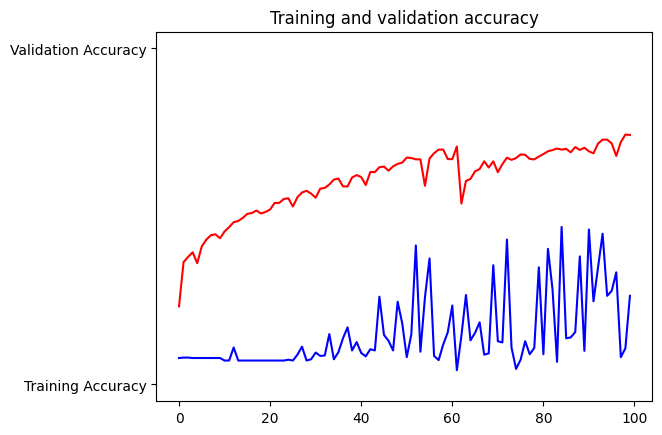

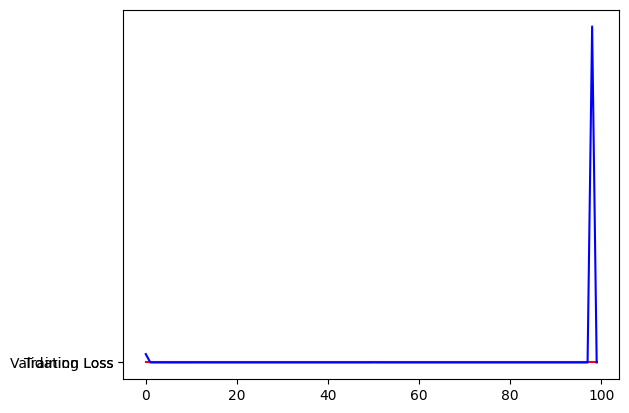

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

### 0,01 - 0,04

#### 0,01

In [10]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,01.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,01.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,01-completed.h5')

Epoch 1/50


2023-12-20 11:15:55.409289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 11:15:57.347889: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 11:15:57.692470: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 11:16:03.076775: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f77df7fdc30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 11:16:03.076805: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 11:16:03.081476: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 11:16:03.240489: I ./tensorflow/compiler/jit/device_compiler.h:1

227/227 [==============================] - ETA: 0s - loss: 1.1134 - accuracy: 0.5034
Epoch 1: val_accuracy improved from -inf to 0.08875, saving model to new_test/new-test-mobile-adam-0,01.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 78s 178ms/step - loss: 1.1134 - accuracy: 0.5034 - val_loss: 12711983.0000 - val_accuracy: 0.0887
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.8617 - accuracy: 0.5789
Epoch 2: val_accuracy did not improve from 0.08875
227/227 [==============================] - 27s 121ms/step - loss: 0.8617 - accuracy: 0.5789 - val_loss: 150194.3906 - val_accuracy: 0.0887
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.7378 - accuracy: 0.6408
Epoch 3: val_accuracy did not improve from 0.08875
227/227 [==============================] - 28s 122ms/step - loss: 0.7378 - accuracy: 0.6408 - val_loss: 14763.8125 - val_accuracy: 0.0887
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.6990
Epoch 4: val_accuracy did not improve from 0.08875
227/227 [==============================] - 27s 119ms/step - loss: 0.6230 - accuracy: 0.6990 - val_loss: 2565.3975 - val_accuracy: 0.0887
Epoc

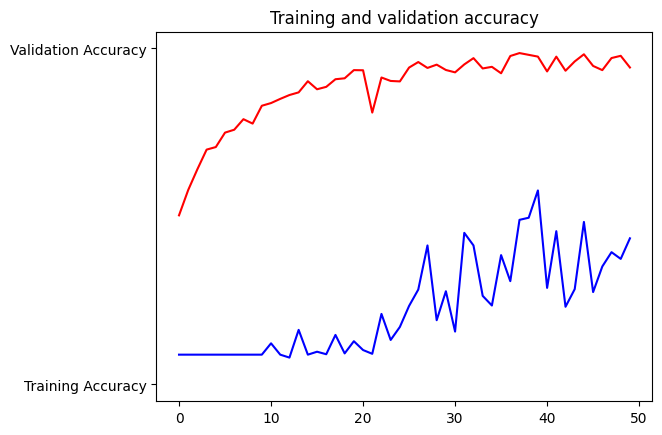

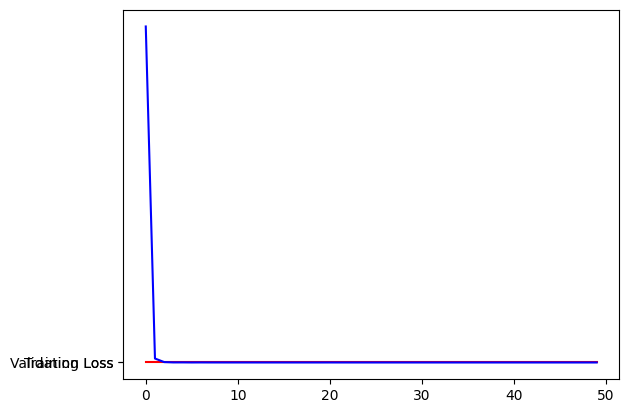

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,02

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.02)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,02.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,02.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,02-completed.h5')

Epoch 1/50


2023-12-20 13:56:57.747268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 13:57:01.073728: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 13:57:01.596604: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 13:57:11.790003: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2de52e4c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 13:57:11.790038: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 13:57:11.796250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 13:57:11.956547: I ./tensorflow/compiler/jit/device_compiler.h:1

227/227 [==============================] - ETA: 0s - loss: 1.3723 - accuracy: 0.4333
Epoch 1: val_accuracy improved from -inf to 0.07375, saving model to new_test/new-test-mobile-adam-0,02.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 104s 228ms/step - loss: 1.3723 - accuracy: 0.4333 - val_loss: 13151795.0000 - val_accuracy: 0.0737
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.0768 - accuracy: 0.5097
Epoch 2: val_accuracy improved from 0.07375 to 0.08875, saving model to new_test/new-test-mobile-adam-0,02.h5
227/227 [==============================] - 28s 124ms/step - loss: 1.0768 - accuracy: 0.5097 - val_loss: 3327241.2500 - val_accuracy: 0.0887
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.8363 - accuracy: 0.5978
Epoch 3: val_accuracy did not improve from 0.08875
227/227 [==============================] - 28s 122ms/step - loss: 0.8363 - accuracy: 0.5978 - val_loss: 74789.2812 - val_accuracy: 0.0887
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.8451 - accuracy: 0.6071
Epoch 4: val_accuracy did not improve from 0.08875
227/227 [==============================] - 28s 123ms/step - loss: 0.8451 - accur

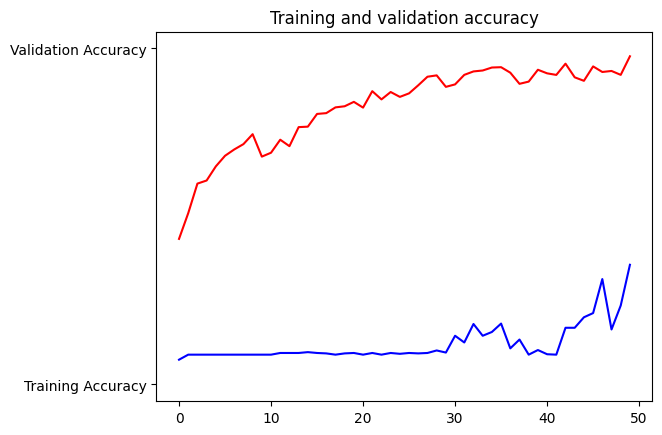

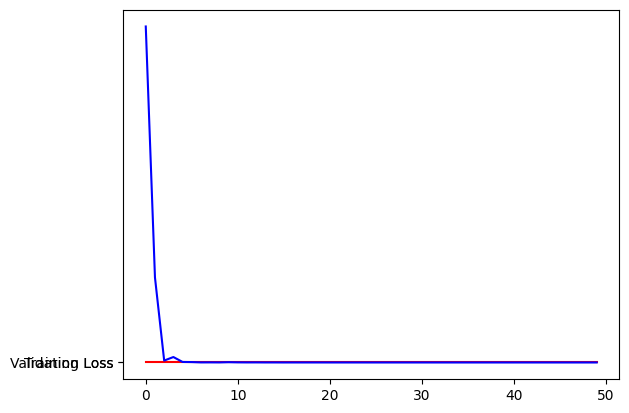

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,03

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.03)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,03.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,03.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,03-completed.h5')

Epoch 1/50


2023-12-20 14:23:51.384523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 14:23:55.925232: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 14:23:56.613752: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 14:24:11.624066: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f023d3ecf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 14:24:11.624124: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 14:24:11.635649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 14:24:11.823103: I ./tensorflow/compiler/jit/device_compiler.h:1

227/227 [==============================] - ETA: 0s - loss: 1.6316 - accuracy: 0.3765
Epoch 1: val_accuracy improved from -inf to 0.07125, saving model to new_test/new-test-mobile-adam-0,03.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 126s 268ms/step - loss: 1.6316 - accuracy: 0.3765 - val_loss: 108864024.0000 - val_accuracy: 0.0712
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.1116 - accuracy: 0.4844
Epoch 2: val_accuracy improved from 0.07125 to 0.11000, saving model to new_test/new-test-mobile-adam-0,03.h5
227/227 [==============================] - 28s 122ms/step - loss: 1.1116 - accuracy: 0.4844 - val_loss: 1225944.3750 - val_accuracy: 0.1100
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.9762 - accuracy: 0.5215
Epoch 3: val_accuracy did not improve from 0.11000
227/227 [==============================] - 27s 118ms/step - loss: 0.9762 - accuracy: 0.5215 - val_loss: 311417.7500 - val_accuracy: 0.0887
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.8480 - accuracy: 0.5693
Epoch 4: val_accuracy did not improve from 0.11000
227/227 [==============================] - 27s 118ms/step - loss: 0.8480 - acc

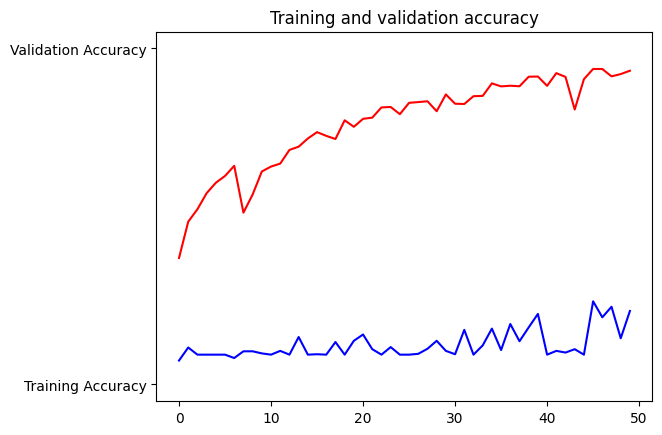

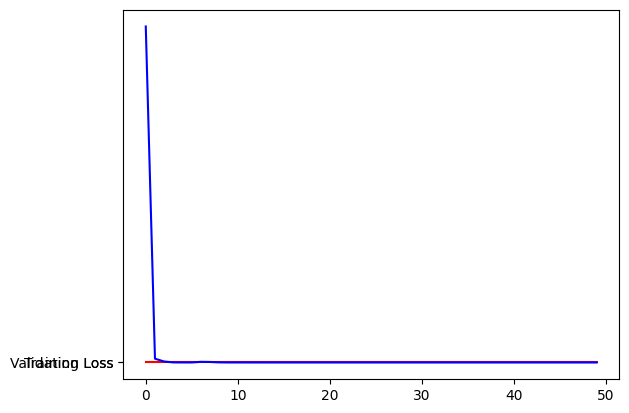

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,04

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.04)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,04.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,04.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,04-completed.h5')

Epoch 1/50


2023-12-20 14:49:48.795049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 14:49:53.367877: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 14:49:54.035592: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 14:50:09.093634: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fac4ab19a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 14:50:09.093679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 14:50:09.131949: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 14:50:09.413246: I ./tensorflow/compiler/jit/device_compiler.h:1

227/227 [==============================] - ETA: 0s - loss: 1.6367 - accuracy: 0.3856
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to new_test/new-test-mobile-adam-0,04.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 127s 269ms/step - loss: 1.6367 - accuracy: 0.3856 - val_loss: 5192780288.0000 - val_accuracy: 0.0938
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.2103 - accuracy: 0.4634
Epoch 2: val_accuracy did not improve from 0.09375
227/227 [==============================] - 27s 119ms/step - loss: 1.2103 - accuracy: 0.4634 - val_loss: 47925608.0000 - val_accuracy: 0.0887
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.9436 - accuracy: 0.5378
Epoch 3: val_accuracy did not improve from 0.09375
227/227 [==============================] - 27s 118ms/step - loss: 0.9436 - accuracy: 0.5378 - val_loss: 1529904.3750 - val_accuracy: 0.0887
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.8754 - accuracy: 0.5702
Epoch 4: val_accuracy did not improve from 0.09375
227/227 [==============================] - 27s 117ms/step - loss: 0.8754 - accuracy: 0.5702 - val_loss: 2266140.2500 - val_accuracy: 0

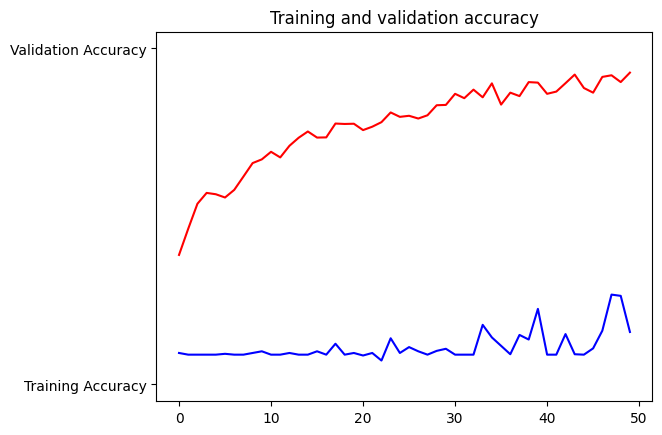

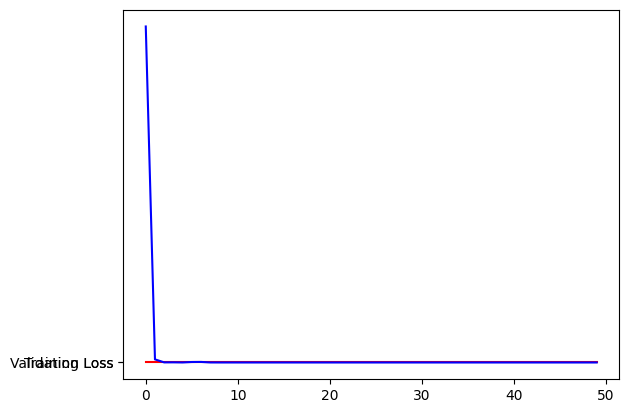

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

### 0,001 - 0,004

#### 0,001

In [8]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,001-completed.h5')

Epoch 1/50


2023-12-19 22:13:08.541181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 22:13:11.802405: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:13:12.289067: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:13:22.644095: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f529e88d0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 22:13:22.644145: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 22:13:22.760624: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.5047 - accuracy: 0.1497
Epoch 1: val_accuracy improved from -inf to 0.12625, saving model to new_test/new-test-mobile-sgd-0,001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 92s 218ms/step - loss: 2.5047 - accuracy: 0.1497 - val_loss: 2.5261 - val_accuracy: 0.1262
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 2.0630 - accuracy: 0.3097
Epoch 2: val_accuracy improved from 0.12625 to 0.18375, saving model to new_test/new-test-mobile-sgd-0,001.h5
227/227 [==============================] - 28s 121ms/step - loss: 2.0630 - accuracy: 0.3097 - val_loss: 2.3642 - val_accuracy: 0.1838
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 1.7957 - accuracy: 0.3939
Epoch 3: val_accuracy improved from 0.18375 to 0.21625, saving model to new_test/new-test-mobile-sgd-0,001.h5
227/227 [==============================] - 27s 121ms/step - loss: 1.7957 - accuracy: 0.3939 - val_loss: 2.2360 - val_accuracy: 0.2163
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 1.6146 - accuracy: 0.4514
Epoch 4: val_accuracy improved from 0.21625 to 0.24875, saving model to new_test/new-test-

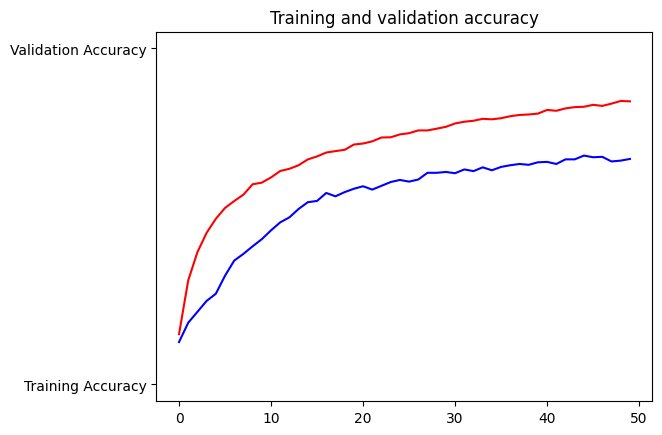

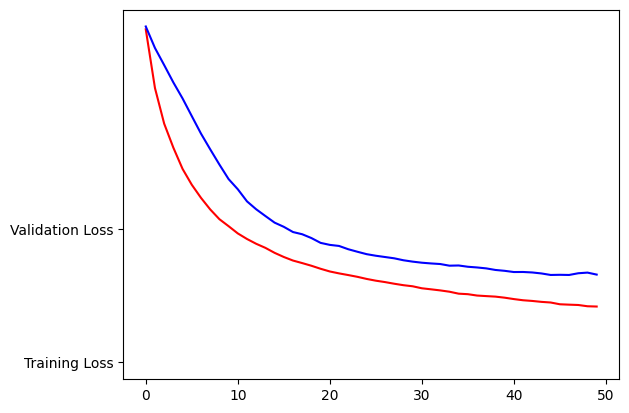

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,002

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.002)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,002.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,002.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,002-completed.h5')

Epoch 1/50


2023-12-19 22:40:15.101545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 22:40:18.289177: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:40:18.801285: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 22:40:28.759947: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd37c13a570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 22:40:28.759980: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 22:40:28.882461: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.2047 - accuracy: 0.2408
Epoch 1: val_accuracy improved from -inf to 0.19625, saving model to new_test/new-test-mobile-sgd-0,002.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 94s 225ms/step - loss: 2.2047 - accuracy: 0.2408 - val_loss: 2.4739 - val_accuracy: 0.1963
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.6927 - accuracy: 0.4170
Epoch 2: val_accuracy improved from 0.19625 to 0.26625, saving model to new_test/new-test-mobile-sgd-0,002.h5
227/227 [==============================] - 28s 121ms/step - loss: 1.6927 - accuracy: 0.4170 - val_loss: 2.2082 - val_accuracy: 0.2663
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 1.3678 - accuracy: 0.4998
Epoch 3: val_accuracy improved from 0.26625 to 0.32875, saving model to new_test/new-test-mobile-sgd-0,002.h5
227/227 [==============================] - 28s 124ms/step - loss: 1.3678 - accuracy: 0.4998 - val_loss: 2.0175 - val_accuracy: 0.3288
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 1.1744 - accuracy: 0.5573
Epoch 4: val_accuracy improved from 0.32875 to 0.35750, saving model to new_test/new-test-

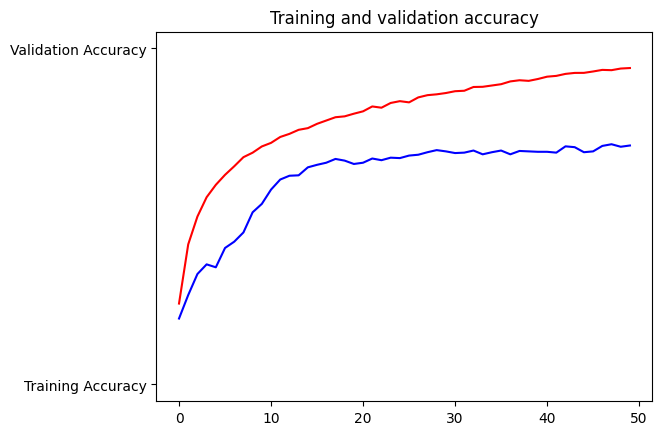

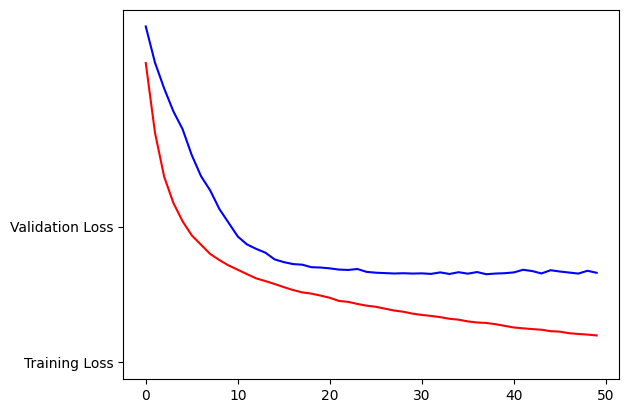

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,003

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.003)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,003.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,003.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,003-completed.h5')

Epoch 1/50


2023-12-19 23:05:27.264444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 23:05:30.468010: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:05:30.974590: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:05:41.072228: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f62146dd240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 23:05:41.072259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 23:05:41.178961: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.0817 - accuracy: 0.2923
Epoch 1: val_accuracy improved from -inf to 0.20875, saving model to new_test/new-test-mobile-sgd-0,003.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 93s 220ms/step - loss: 2.0817 - accuracy: 0.2923 - val_loss: 2.2472 - val_accuracy: 0.2087
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.4518 - accuracy: 0.4864
Epoch 2: val_accuracy improved from 0.20875 to 0.29250, saving model to new_test/new-test-mobile-sgd-0,003.h5
227/227 [==============================] - 27s 120ms/step - loss: 1.4518 - accuracy: 0.4864 - val_loss: 1.9772 - val_accuracy: 0.2925
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 1.1390 - accuracy: 0.5700
Epoch 3: val_accuracy improved from 0.29250 to 0.33250, saving model to new_test/new-test-mobile-sgd-0,003.h5
227/227 [==============================] - 27s 119ms/step - loss: 1.1390 - accuracy: 0.5700 - val_loss: 1.7859 - val_accuracy: 0.3325
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.9612 - accuracy: 0.6187
Epoch 4: val_accuracy improved from 0.33250 to 0.36875, saving model to new_test/new-test-

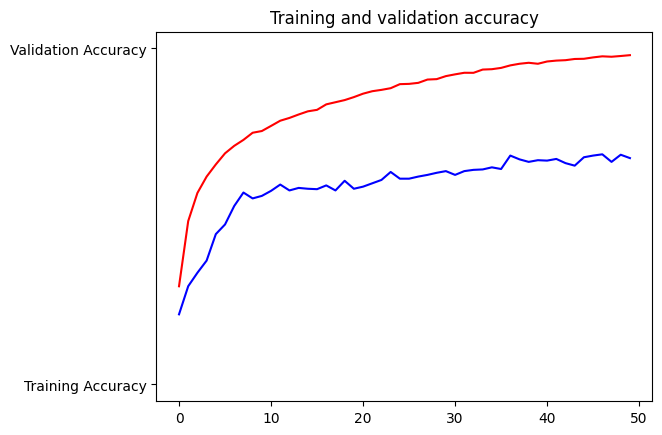

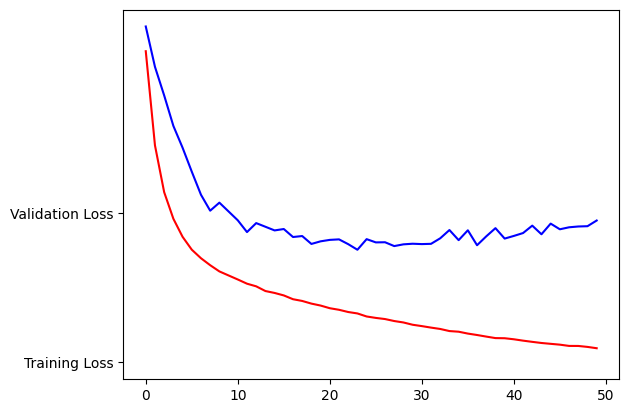

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,004

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.004)
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-sgd-0,004.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-sgd-0,004.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-sgd-0,004-completed.h5')

Epoch 1/50


2023-12-19 23:31:42.926619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 23:31:46.032057: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:31:46.518246: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-19 23:31:56.657192: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55fd67c816b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 23:31:56.657253: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-19 23:31:56.782031: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.3328
Epoch 1: val_accuracy improved from -inf to 0.19125, saving model to new_test/new-test-mobile-sgd-0,004.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 93s 224ms/step - loss: 1.9463 - accuracy: 0.3328 - val_loss: 2.3827 - val_accuracy: 0.1912
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.2537 - accuracy: 0.5291
Epoch 2: val_accuracy improved from 0.19125 to 0.25500, saving model to new_test/new-test-mobile-sgd-0,004.h5
227/227 [==============================] - 27s 121ms/step - loss: 1.2537 - accuracy: 0.5291 - val_loss: 2.0349 - val_accuracy: 0.2550
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.9643 - accuracy: 0.6112
Epoch 3: val_accuracy improved from 0.25500 to 0.32875, saving model to new_test/new-test-mobile-sgd-0,004.h5
227/227 [==============================] - 28s 122ms/step - loss: 0.9643 - accuracy: 0.6112 - val_loss: 1.7675 - val_accuracy: 0.3288
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.6573
Epoch 4: val_accuracy improved from 0.32875 to 0.37125, saving model to new_test/new-test-

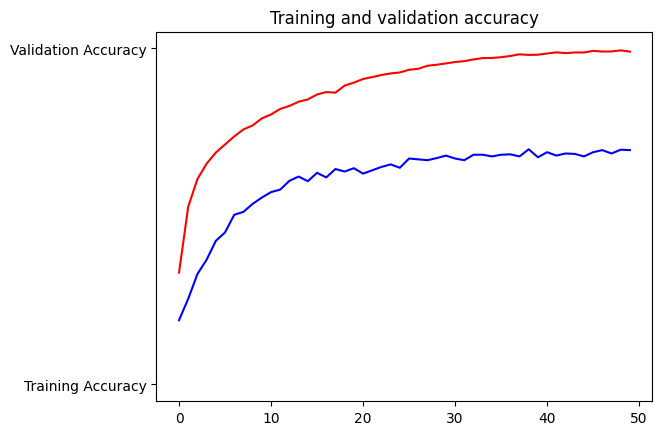

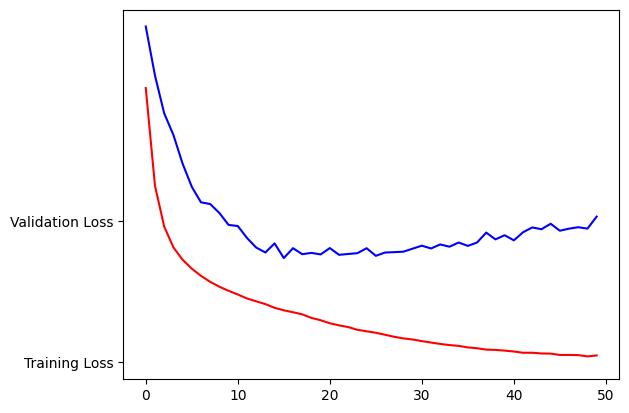

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

### 0,0001 - 0,0004

#### 0,0001

In [8]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,0001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,0001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,0001-completed.h5')

Epoch 1/100


2023-12-28 13:45:19.351500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-28 13:45:20.634411: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 13:45:20.799638: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-28 13:45:22.093486: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56216858e6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 13:45:22.093549: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-28 13:45:22.158053: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-28 13:45:22.520277: I ./tensorflow/compiler/jit/device_compiler.h:1

453/453 [==============================] - ETA: 0s - loss: 1.2671 - accuracy: 0.5106
Epoch 1: val_accuracy improved from -inf to 0.22500, saving model to new_test/new-test-mobile-adam-0,0001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 102s 153ms/step - loss: 1.2671 - accuracy: 0.5106 - val_loss: 2.0758 - val_accuracy: 0.2250
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.7142
Epoch 2: val_accuracy improved from 0.22500 to 0.27875, saving model to new_test/new-test-mobile-adam-0,0001.h5
453/453 [==============================] - 32s 71ms/step - loss: 0.6604 - accuracy: 0.7142 - val_loss: 1.8652 - val_accuracy: 0.2788
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.7871
Epoch 3: val_accuracy improved from 0.27875 to 0.42875, saving model to new_test/new-test-mobile-adam-0,0001.h5
453/453 [==============================] - 33s 72ms/step - loss: 0.5022 - accuracy: 0.7871 - val_loss: 1.3394 - val_accuracy: 0.4288
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.8334
Epoch 4: val_accuracy improved from 0.42875 to 0.45500, saving model to new_test/new

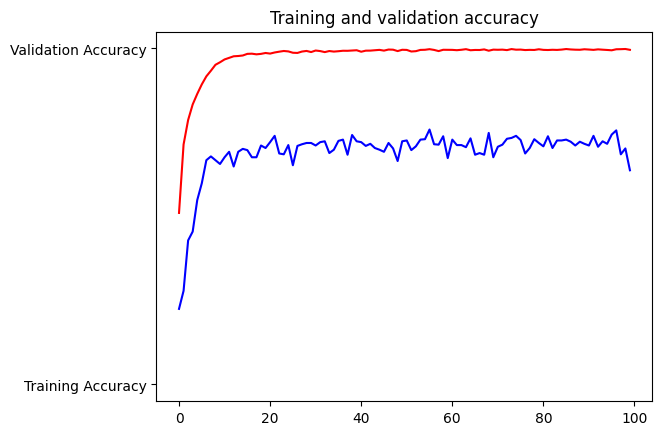

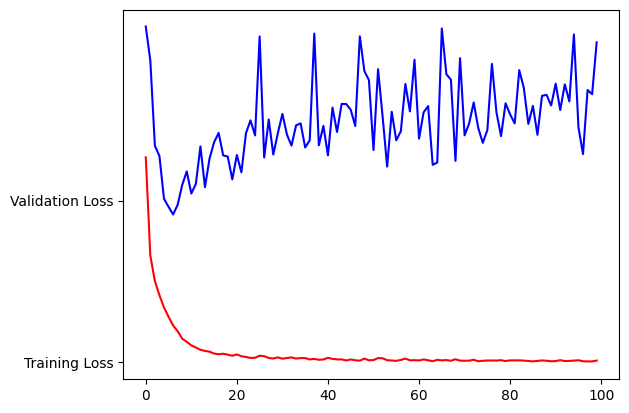

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,0002

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,0002.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,0002.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,0002-completed.h5')

Epoch 1/50


2023-12-20 15:49:29.320437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 15:49:32.580665: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 15:49:33.071596: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 15:49:43.329796: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5588c1ff8eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 15:49:43.329855: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 15:49:43.342884: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 15:49:43.501375: I ./tensorflow/compiler/jit/device_compiler.h:1

227/227 [==============================] - ETA: 0s - loss: 1.1209 - accuracy: 0.5422
Epoch 1: val_accuracy improved from -inf to 0.11625, saving model to new_test/new-test-mobile-adam-0,0002.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 103s 223ms/step - loss: 1.1209 - accuracy: 0.5422 - val_loss: 2.6088 - val_accuracy: 0.1163
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.7518
Epoch 2: val_accuracy improved from 0.11625 to 0.13000, saving model to new_test/new-test-mobile-adam-0,0002.h5
227/227 [==============================] - 27s 117ms/step - loss: 0.5542 - accuracy: 0.7518 - val_loss: 2.6612 - val_accuracy: 0.1300
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8309
Epoch 3: val_accuracy improved from 0.13000 to 0.23250, saving model to new_test/new-test-mobile-adam-0,0002.h5
227/227 [==============================] - 27s 120ms/step - loss: 0.4094 - accuracy: 0.8309 - val_loss: 2.0547 - val_accuracy: 0.2325
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.8772
Epoch 4: val_accuracy improved from 0.23250 to 0.25000, saving model to new_test/new-

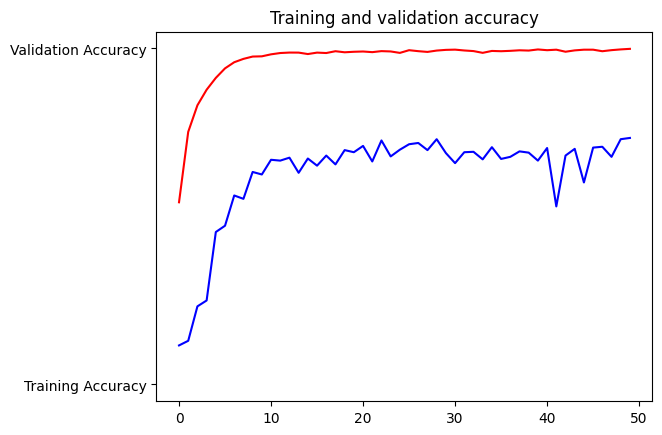

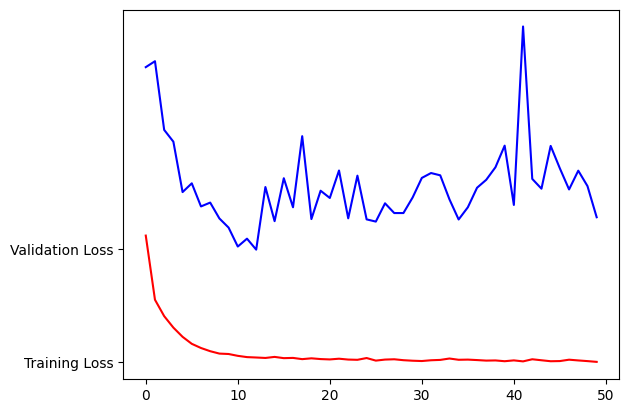

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,0003

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,0003.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,0003.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,0003-completed.h5')

Epoch 1/50


2023-12-20 16:19:58.846665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 16:20:01.813869: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 16:20:02.274668: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 16:20:12.518752: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f11740092e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 16:20:12.518814: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 16:20:12.532006: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 16:20:12.693211: I ./tensorflow/compiler/jit/device_compiler.h:1

227/227 [==============================] - ETA: 0s - loss: 0.9995 - accuracy: 0.5812
Epoch 1: val_accuracy improved from -inf to 0.19750, saving model to new_test/new-test-mobile-adam-0,0003.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 103s 226ms/step - loss: 0.9995 - accuracy: 0.5812 - val_loss: 2.6976 - val_accuracy: 0.1975
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.7752
Epoch 2: val_accuracy did not improve from 0.19750
227/227 [==============================] - 27s 118ms/step - loss: 0.5015 - accuracy: 0.7752 - val_loss: 2.6735 - val_accuracy: 0.1900
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.3612 - accuracy: 0.8499
Epoch 3: val_accuracy improved from 0.19750 to 0.22000, saving model to new_test/new-test-mobile-adam-0,0003.h5
227/227 [==============================] - 28s 122ms/step - loss: 0.3612 - accuracy: 0.8499 - val_loss: 2.5572 - val_accuracy: 0.2200
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8988
Epoch 4: val_accuracy improved from 0.22000 to 0.22625, saving model to new_test/new-test-mobile-adam-0,0003.h5
227/227 [=========================

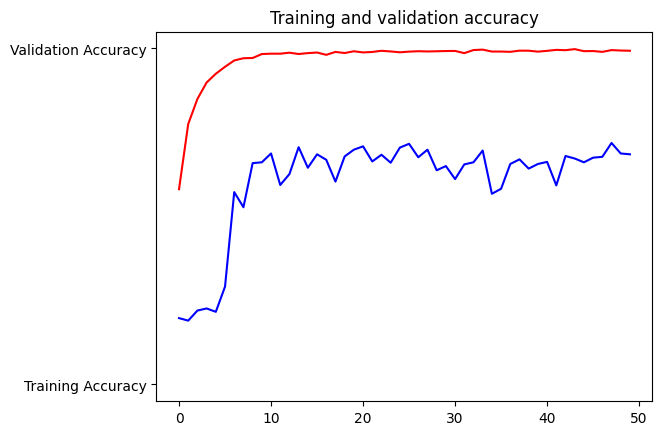

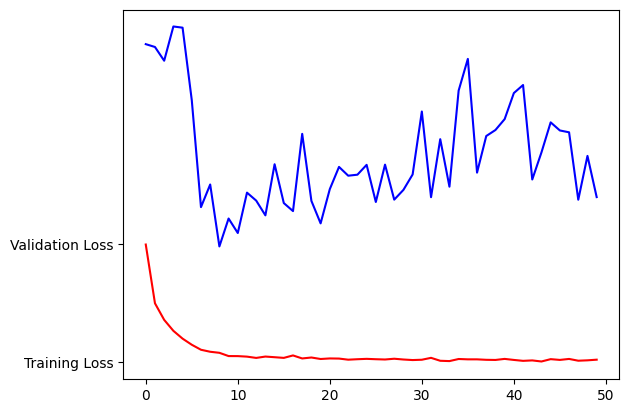

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

#### 0,0004

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0004)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-adam-0,0004.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-adam-0,0004.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model.save('new_test/new-test-mobile-adam-0,0004-completed.h5')

Epoch 1/50


2023-12-20 16:45:32.743428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-20 16:45:35.965961: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 16:45:36.489828: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 16:45:46.709623: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558d52c726f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 16:45:46.709700: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2023-12-20 16:45:46.722037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 16:45:46.860182: I ./tensorflow/compiler/jit/device_compiler.h:1

227/227 [==============================] - ETA: 0s - loss: 0.9483 - accuracy: 0.5955
Epoch 1: val_accuracy improved from -inf to 0.25750, saving model to new_test/new-test-mobile-adam-0,0004.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 103s 227ms/step - loss: 0.9483 - accuracy: 0.5955 - val_loss: 2.3001 - val_accuracy: 0.2575
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8019
Epoch 2: val_accuracy did not improve from 0.25750
227/227 [==============================] - 27s 120ms/step - loss: 0.4611 - accuracy: 0.8019 - val_loss: 2.4472 - val_accuracy: 0.2400
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8609
Epoch 3: val_accuracy improved from 0.25750 to 0.27750, saving model to new_test/new-test-mobile-adam-0,0004.h5
227/227 [==============================] - 28s 122ms/step - loss: 0.3414 - accuracy: 0.8609 - val_loss: 2.3069 - val_accuracy: 0.2775
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8998
Epoch 4: val_accuracy improved from 0.27750 to 0.30750, saving model to new_test/new-test-mobile-adam-0,0004.h5
227/227 [=========================

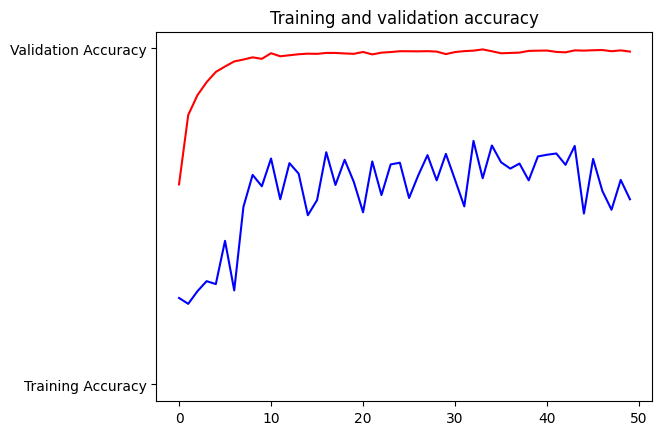

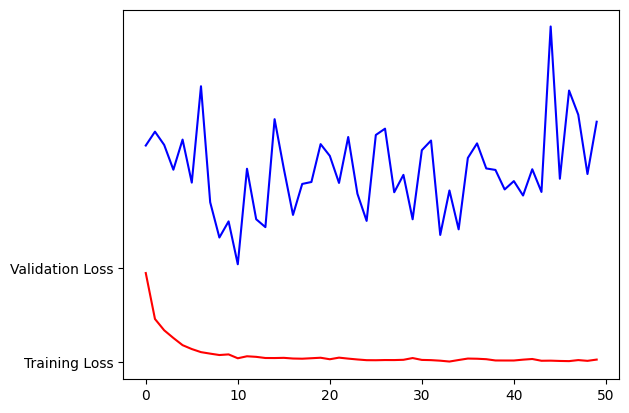

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_mobile=train_mobile.history['accuracy']
val_acc_mobile=train_mobile.history['val_accuracy']
loss_mobile=train_mobile.history['loss']
val_loss_mobile=train_mobile.history['val_loss']

epochs2=range(len(acc_mobile)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs2, acc_mobile, 'r', "Training Accuracy")
plt.plot(epochs2, val_acc_mobile, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs2, loss_mobile, 'r', "Training Loss")
plt.plot(epochs2, val_loss_mobile, 'b', "Validation Loss")
plt.show()

# MobileNet add Dropout()

### Dropout 0,1

In [ ]:
x3 = pretrained_mobile.output
x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
x3 = tf.keras.layers.Dropout(0.1)(x3)
predictions3 = tf.keras.layers.Dense(12, activation='softmax')(x3)
model3 = tf.keras.Model(inputs=pretrained_mobile.input, outputs=predictions3)
#model2.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0004)
model3.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-[optimizer]-dropout-0,1.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-[optimizer]-dropout-0,1.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile_d3 = model3.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model3.save('new_test/new-test-mobile-[optimizer]-dropout-0,1-completed.h5')

### Dropout 0,2

In [ ]:
x4 = pretrained_mobile.output
x4 = tf.keras.layers.GlobalAveragePooling2D()(x4)
x4 = tf.keras.layers.Dropout(0.2)(x3)
predictions4 = tf.keras.layers.Dense(12, activation='softmax')(x4)
model4 = tf.keras.Model(inputs=pretrained_mobile.input, outputs=predictions4)
#model2.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0004)
model4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-[optimizer]-dropout-0,2.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-[optimizer]-dropout-0,2.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile_d4 = model4.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model4.save('new_test/new-test-mobile-[optimizer]-dropout-0,1-completed.h5')

### Dropout 0,3

In [ ]:
x5 = pretrained_mobile.output
x5 = tf.keras.layers.GlobalAveragePooling2D()(x5)
x5 = tf.keras.layers.Dropout(0.3)(x5)
predictions5 = tf.keras.layers.Dense(12, activation='softmax')(x5)
model5 = tf.keras.Model(inputs=pretrained_mobile.input, outputs=predictions5)
#model2.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0004)
model5.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-[optimizer]-0,3.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-[optimizer]-dropout-0,3.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile_d5 = model5.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model5.save('new_test/new-test-mobile-[optimizer]-dropout-0,3.h5')

### Dropout 0,4

In [ ]:
x6 = pretrained_mobile.output
x6 = tf.keras.layers.GlobalAveragePooling2D()(x6)
x6 = tf.keras.layers.Dropout(0.4)(x6)
predictions6 = tf.keras.layers.Dense(12, activation='softmax')(x6)
model6 = tf.keras.Model(inputs=pretrained_mobile.input, outputs=predictions6)
#model2.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0004)
model6.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-[optimizer]-dropout-0,4.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-[optimizer]-dropout-0,4.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile_d6 = model6.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model6.save('new_test/new-test-mobile-[optimizer]-dropout-0,4-completed.h5')

### Dropout 0,5

In [ ]:
x7 = pretrained_mobile.output
x7 = tf.keras.layers.GlobalAveragePooling2D()(x7)
x7 = tf.keras.layers.Dropout(0.5)(x7)
predictions7 = tf.keras.layers.Dense(12, activation='softmax')(x7)
model7 = tf.keras.Model(inputs=pretrained_mobile.input, outputs=predictions7)
#model2.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
adam = tf.keras.optimizers.Adam(learning_rate=0.0004)
model7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-mobile-[optimizer]-dropout-0,5.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new_test/new-test-mobile-[optimizer]-dropout-0,5.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log]
train_mobile_d7 = model7.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=50,
                    callbacks = callbacksList,
                    verbose=1)
model7.save('new_test/new-test-mobile-[optimizer]-dropout-0,5-completed.h5')